<a href="https://colab.research.google.com/github/giolml/Movies_Analysis/blob/main/EDA_Movies_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import dask.dataframe as dd
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

global df_title_basics,df_title_ratings,df_tmdb

Mounted at /content/drive


In [ ]:
#df_title_basics = dd.read_csv(r'/content/drive/MyDrive/Bootcamp_DataScience_Xperience/Junio 2024/title.basics.tsv', dtype={'isAdult': 'object', 'runtimeMinutes': 'object', 'startYear': 'object'}, delimiter='\t', low_memory=False)

# Carga de base title_basics mediante Dask y conversión a Pandas
df_title_basics = dd.read_csv(r'/content/drive/MyDrive/title.basics.tsv', dtype={'isAdult': 'object', 'runtimeMinutes': 'object', 'startYear': 'object'}, delimiter='\t', low_memory=False).compute()
df_title_basics = pd.DataFrame(df_title_basics.compute()) if 'dask' in str(type(df_title_basics)) else df_title_basics

# Carga de base title_ratings mediante Dask y conversión a Pandas
df_title_ratings = dd.read_csv(r'/content/drive/MyDrive/title.ratings.tsv', delimiter='\t', low_memory=False)
df_title_ratings = pd.DataFrame(df_title_ratings.compute()) if 'dask' in str(type(df_title_ratings)) else df_title_ratings

# Carga de base tmdb mediante Dask y conversión a Pandas
df_tmdb = dd.read_csv(r'/content/drive/MyDrive/TMDB_movie_dataset_v11.csv', low_memory=False)
df_tmdb = pd.DataFrame(df_tmdb.compute()) if 'dask' in str(type(df_tmdb)) else df_tmdb

In [ ]:
#df_title_basics.titleType.value_counts(normalize=True).compute()
df_title_basics['titleType'].value_counts(normalize=True)

titleType
tvEpisode      0.77
short          0.09
movie          0.06
video          0.03
tvSeries       0.02
tvMovie        0.01
tvMiniSeries   0.01
tvSpecial      0.00
videoGame      0.00
tvShort        0.00
tvPilot        0.00
Name: proportion, dtype: double[pyarrow]

In [ ]:
#@title
def preprocesamiento():
  global df_title_basics,df_title_ratings,df_tmdb

  # df_title_basics
  #df_title_basics = df_title_basics.loc[df_title_basics['titleType'].isin(['tvSeries', 'movie'])].compute() # Elimina los registros de df_title_basics diferentes de 'tvSeries','movie'.
  df_title_basics = df_title_basics[df_title_basics['titleType'].isin(['tvSeries', 'movie'])] # Elimina los registros de df_title_basics diferentes de 'tvSeries','movie'.
  df_title_basics = df_title_basics.drop(columns=['endYear']) # Eliminar la columna 'endYear'
  df_title_basics['startYear'] = pd.to_numeric(df_title_basics['startYear'], errors='coerce')
  df_title_basics = df_title_basics[(df_title_basics['startYear'] >= 1970) & (df_title_basics['startYear'] <= 2024)] # Elimino los registros con 'startYear menor a 1970' y menor a '2024'

  df_title_basics.replace('\\N', np.nan, inplace=True) # Reemplazar las cadenas '\\N' por NaN
  df_title_basics.dropna(inplace=True) # Eliminar los registros que contienen valores nulos

  df_title_basics['tconst'] = df_title_basics['tconst'].astype('object')
  df_title_basics['titleType'] = df_title_basics['titleType'].astype('object')
  df_title_basics['primaryTitle'] = df_title_basics['primaryTitle'].astype('object')
  df_title_basics['originalTitle'] = df_title_basics['originalTitle'].astype('object')
  df_title_basics['isAdult'] = df_title_basics['isAdult'].astype('int8')
  df_title_basics['genres'] = df_title_basics['genres'].astype('object')
  df_title_basics['runtimeMinutes'] = pd.to_numeric(df_title_basics['runtimeMinutes'], errors='coerce')

  # df_title_ratings
  df_title_ratings = df_title_ratings[df_title_ratings['tconst'].isin(df_title_basics['tconst'])]
  df_title_ratings.replace('\\N', np.nan, inplace=True) # Reemplazar las cadenas '\\N' por NaN
  df_title_ratings.dropna(inplace=True) # Eliminar los registros que contienen valores nulos

  df_title_ratings['tconst'] = df_title_ratings['tconst'].astype('object')

  # df_tmdb
  df_tmdb = df_tmdb.drop(columns=['overview', 'poster_path', 'tagline', 'keywords', 'backdrop_path', 'homepage', 'status', 'spoken_languages', 'production_companies'])
  # Elimina los registros de df_tmdb donde 'budget' y 'revenue' sean menores o iguales a cero.
  df_tmdb = df_tmdb[(df_tmdb['budget'] > 0) & (df_tmdb['revenue'] > 0)]

  df_tmdb['imdb_id'] = df_tmdb['imdb_id'].replace('\\N', np.nan) # Reemplazar '\\N' por NaN en la columna 'imdb_id'
  df_tmdb.drop_duplicates(subset=['imdb_id'], inplace=True) # Eliminar los registros duplicados en la columna 'imdb_id'
  df_tmdb = df_tmdb.dropna(subset=['imdb_id']) # Eliminar los registros que contienen valores nulos

  # Reemplazar las cadenas '\\N' por NaN y Elimina registros que contienen valores nulos
  df_tmdb.replace('\\N', np.nan, inplace=True)
  df_tmdb.dropna(inplace=True)

  df_title_ratings['tconst'] = df_title_ratings['tconst'].astype('object')

  df_tmdb['title'] = df_tmdb['title'].astype('object')
  df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors='coerce')
  df_tmdb['imdb_id'] = df_tmdb['imdb_id'].astype('object')
  df_tmdb['original_language'] = df_tmdb['original_language'].astype('object')
  df_tmdb['original_title'] = df_tmdb['original_title'].astype('object')

  # Elimina todos los registros duplicados, especialmente de la columna llave 'tconst','imdb_id', de cada uno de los 3 dataframes.

  df_title_basics.drop_duplicates(subset=['tconst'], inplace=True)
  df_title_ratings.drop_duplicates(subset=['tconst'], inplace=True)
  df_tmdb.drop_duplicates(subset=['imdb_id'], inplace=True)

  # Crea una nueva columna en df_tmdb llamada roi que es calculada como la resta de (revenue - budget)dividido por budget.
  df_tmdb['roi'] = (df_tmdb['revenue'] - df_tmdb['budget']) / df_tmdb['budget']

  # Convertir la columna 'release_date' a formato datetime
  df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors='coerce')
  # Definir las fechas límite
  fecha_inicio = pd.Timestamp('1970-01-01')
  fecha_fin = pd.Timestamp(datetime.today().strftime('%Y-%m-%d'))
  # Filtrar el DataFrame
  df_tmdb = df_tmdb[(df_tmdb['release_date'] >= fecha_inicio) & (df_tmdb['release_date'] <= fecha_fin)]

In [ ]:
preprocesamiento()
print(df_title_basics.info())
print('-------------')
print(df_title_ratings.info())
print('-------------')
print(df_tmdb.info())

<ipython-input-4-b8f45c938f7b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title_ratings.replace('\\N', np.nan, inplace=True) # Reemplazar las cadenas '\\N' por NaN
<ipython-input-4-b8f45c938f7b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title_ratings.dropna(inplace=True) # Eliminar los registros que contienen valores nulos
<ipython-input-4-b8f45c938f7b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

<class 'pandas.core.frame.DataFrame'>
Index: 419610 entries, 13079 to 784328
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          419610 non-null  object
 1   titleType       419610 non-null  object
 2   primaryTitle    419610 non-null  object
 3   originalTitle   419610 non-null  object
 4   isAdult         419610 non-null  int8  
 5   startYear       419610 non-null  Int64 
 6   runtimeMinutes  419610 non-null  Int64 
 7   genres          419610 non-null  object
dtypes: Int64(2), int8(1), object(5)
memory usage: 26.8+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
Index: 274698 entries, 3846 to 1446036
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   tconst         274698 non-null  object 
 1   averageRating  274698 non-null  float64
 2   numVotes       274698 non-null  int64  
dtypes: float64(1), int64(1)

Estadísticas de los datos originales:
count      9363.00
mean        637.49
std       34547.35
min          -1.00
25%          -0.38
50%           0.67
75%           2.73
max     2755583.00
Name: roi, dtype: float64

Estadísticas de los datos sin outliers:
count   8466.00
mean       1.00
std        1.90
min       -1.00
25%       -0.48
50%        0.40
75%        1.92
max        7.40
Name: roi, dtype: float64

Valores de ROI en el DataFrame sin outliers:
0   4.16
1   3.25
2   4.43
4   5.90
6   5.84
Name: roi, dtype: float64


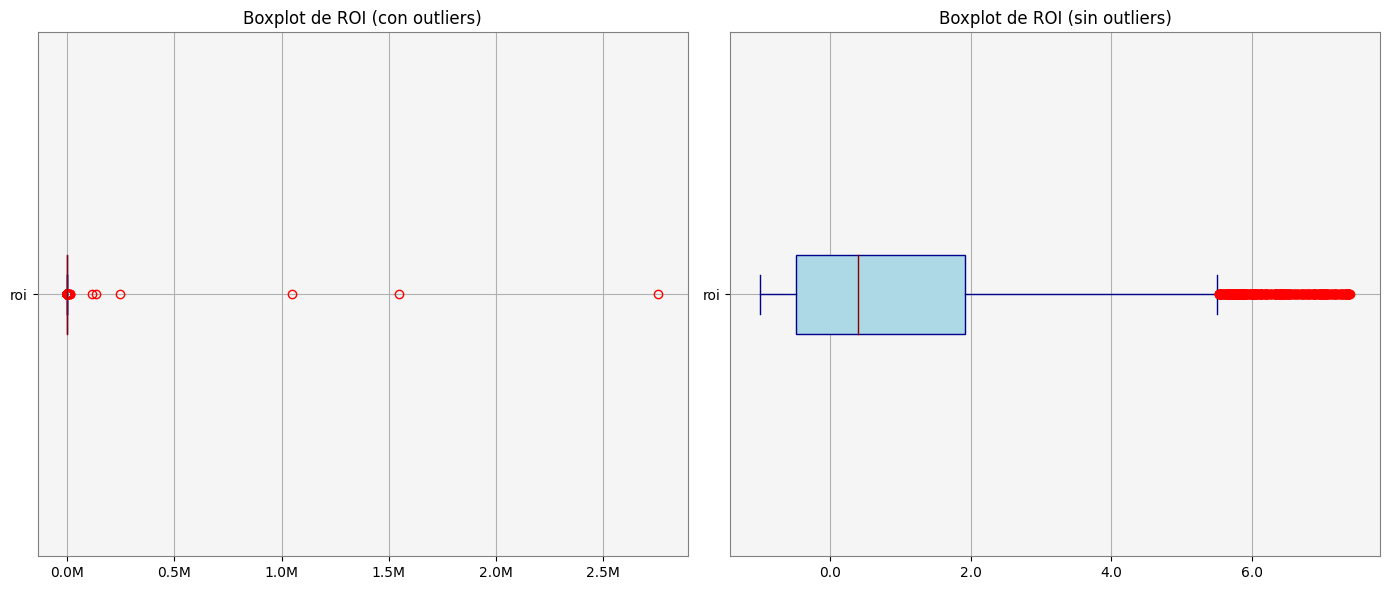

In [ ]:
# Funciones para formatear las etiquetas del eje Y
def format_units(x, pos):
    return '%1.1f' % x

def format_hundreds(x, pos):
    return '%1.1fH' % (x * 1e-2)

def format_thousands(x, pos):
    return '%1.1fK' % (x * 1e-3)

def format_millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

# Copia del DataFrame para la versión con outliers
df_tmdb_con_outliers = df_tmdb.copy()

# Calcular los límites para eliminar outliers
valor = df_tmdb['roi']
Q1 = valor.quantile(0.25)
Q3 = valor.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar outliers
seleccion = (valor >= limite_inferior) & (valor <= limite_superior)
df_tmdb = df_tmdb[seleccion]

# Imprimir estadísticas de los datos originales y filtrados
print("Estadísticas de los datos originales:")
print(df_tmdb_con_outliers['roi'].describe())
print("\nEstadísticas de los datos sin outliers:")
print(df_tmdb['roi'].describe())

# Verificar los valores de la columna 'roi' en el DataFrame filtrado
print("\nValores de ROI en el DataFrame sin outliers:")
print(df_tmdb['roi'].head())

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Determinar el formateador adecuado para cada gráfico
if df_tmdb_con_outliers['roi'].max() > 1e6:
    formatter_original = FuncFormatter(format_millions)
elif df_tmdb_con_outliers['roi'].max() > 1e3:
    formatter_original = FuncFormatter(format_thousands)
else:
    formatter_original = FuncFormatter(format_units)

if df_tmdb['roi'].max() > 1e6:
    formatter_no_outliers = FuncFormatter(format_millions)
elif df_tmdb['roi'].max() > 1e3:
    formatter_no_outliers = FuncFormatter(format_thousands)
else:
    formatter_no_outliers = FuncFormatter(format_units)

# Personalizar el estilo de los boxplots
boxplot_props = dict(patch_artist=True, boxprops=dict(facecolor='lightblue', color='darkblue'),
                     capprops=dict(color='darkblue'), whiskerprops=dict(color='darkblue'),
                     flierprops=dict(color='red', markeredgecolor='red'), medianprops=dict(color='darkred'))

# Boxplot con outliers
df_tmdb_con_outliers.boxplot(column=['roi'], ax=axes[0], vert=False, **boxplot_props)
axes[0].set_title('Boxplot de ROI (con outliers)')
axes[0].xaxis.set_major_formatter(formatter_original)

# Boxplot sin outliers
df_tmdb.boxplot(column=['roi'], ax=axes[1], vert=False, **boxplot_props)
axes[1].set_title('Boxplot de ROI (sin outliers)')
axes[1].xaxis.set_major_formatter(formatter_no_outliers)

# Cambiar el color de fondo de los gráficos
for ax in axes:
    ax.set_facecolor('#f5f5f5')
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [ ]:
#@title
# Inspección de los atributos de df_title_basics
print('-----------------------------------------------------------------')
print(df_title_basics.info())
print('-----------------------------------------------------------------')

# Inspección de los atributos de df_title_ratings
print('-----------------------------------------------------------------')
print(df_title_ratings.info())
print('-----------------------------------------------------------------')

# Inspección de los atributos de df_tmdb
print('-----------------------------------------------------------------')
print(df_tmdb.info())
print('-----------------------------------------------------------------')

-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 419610 entries, 13079 to 784328
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          419610 non-null  object
 1   titleType       419610 non-null  object
 2   primaryTitle    419610 non-null  object
 3   originalTitle   419610 non-null  object
 4   isAdult         419610 non-null  int8  
 5   startYear       419610 non-null  Int64 
 6   runtimeMinutes  419610 non-null  Int64 
 7   genres          419610 non-null  object
dtypes: Int64(2), int8(1), object(5)
memory usage: 26.8+ MB
None
-----------------------------------------------------------------
-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 274698 entries, 3846 to 1446036
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         ----

In [ ]:
# Descripción de los datos numéricos de df_title_basics
print(df_title_basics.describe())
print('-----------------------------------------------------------------')
print('-----------------------------------------------------------------')

# Descripción de los datos numéricos de df_title_ratings
print(df_title_ratings.describe())
print('-----------------------------------------------------------------')
print('-----------------------------------------------------------------')

# Descripción de los datos numéricos de df_tmdb
print(df_tmdb.describe())
print('-----------------------------------------------------------------')
print('-----------------------------------------------------------------')

        isAdult  startYear  runtimeMinutes
count 419610.00  419610.00       419610.00
mean       0.01    2006.91           81.72
std        0.12      14.11          157.26
min        0.00    1970.00            1.00
25%        0.00    2000.00           58.00
50%        0.00    2011.00           85.00
75%        0.00    2018.00           98.00
max        1.00    2024.00        59460.00
-----------------------------------------------------------------
-----------------------------------------------------------------
       averageRating   numVotes
count      274698.00  274698.00
mean            6.29    4394.91
std             1.43   39846.98
min             1.00       5.00
25%             5.40      22.00
50%             6.40      81.00
75%             7.30     425.00
max            10.00 2904305.00
-----------------------------------------------------------------
-----------------------------------------------------------------
              id  vote_average  vote_count                   

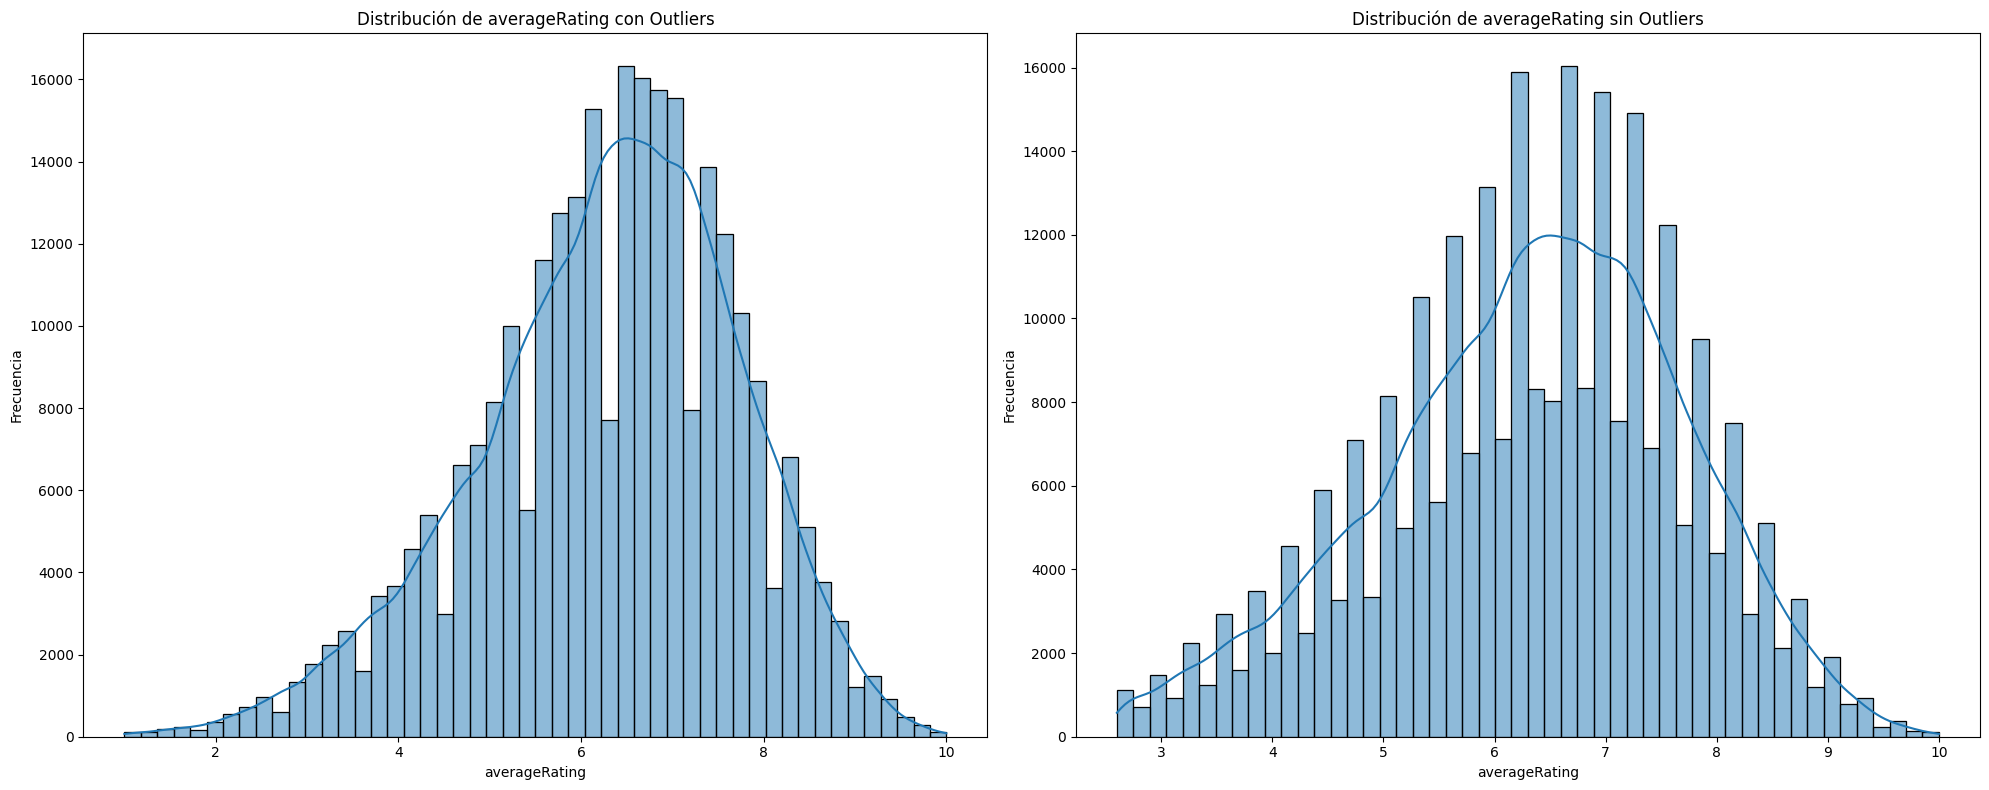

In [ ]:
# Configurar el tamaño de la figura
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Histograma con outliers
sns.histplot(df_title_ratings['averageRating'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribución de averageRating con Outliers')
axes[0].set_xlabel('averageRating')
axes[0].set_ylabel('Frecuencia')

# Calcular los límites para los outliers
valorAverageRating = df_title_ratings['averageRating']
Q1 = valorAverageRating.quantile(0.25)
Q3 = valorAverageRating.quantile(0.75)
IIQAR = Q3 - Q1
limite_inferior_valorAverageRating = Q1 - 1.5 * IIQAR
limite_superior_valorAverageRating = Q3 + 1.5 * IIQAR

# Seleccionar los datos sin outliers
seleccionvalorAverageRating = (valorAverageRating >= limite_inferior_valorAverageRating) & (valorAverageRating <= limite_superior_valorAverageRating)
df_sin_outliers = df_title_ratings[seleccionvalorAverageRating]

# Histograma sin outliers
sns.histplot(df_sin_outliers['averageRating'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribución de averageRating sin Outliers')
axes[1].set_xlabel('averageRating')
axes[1].set_ylabel('Frecuencia')

# Ajustar diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

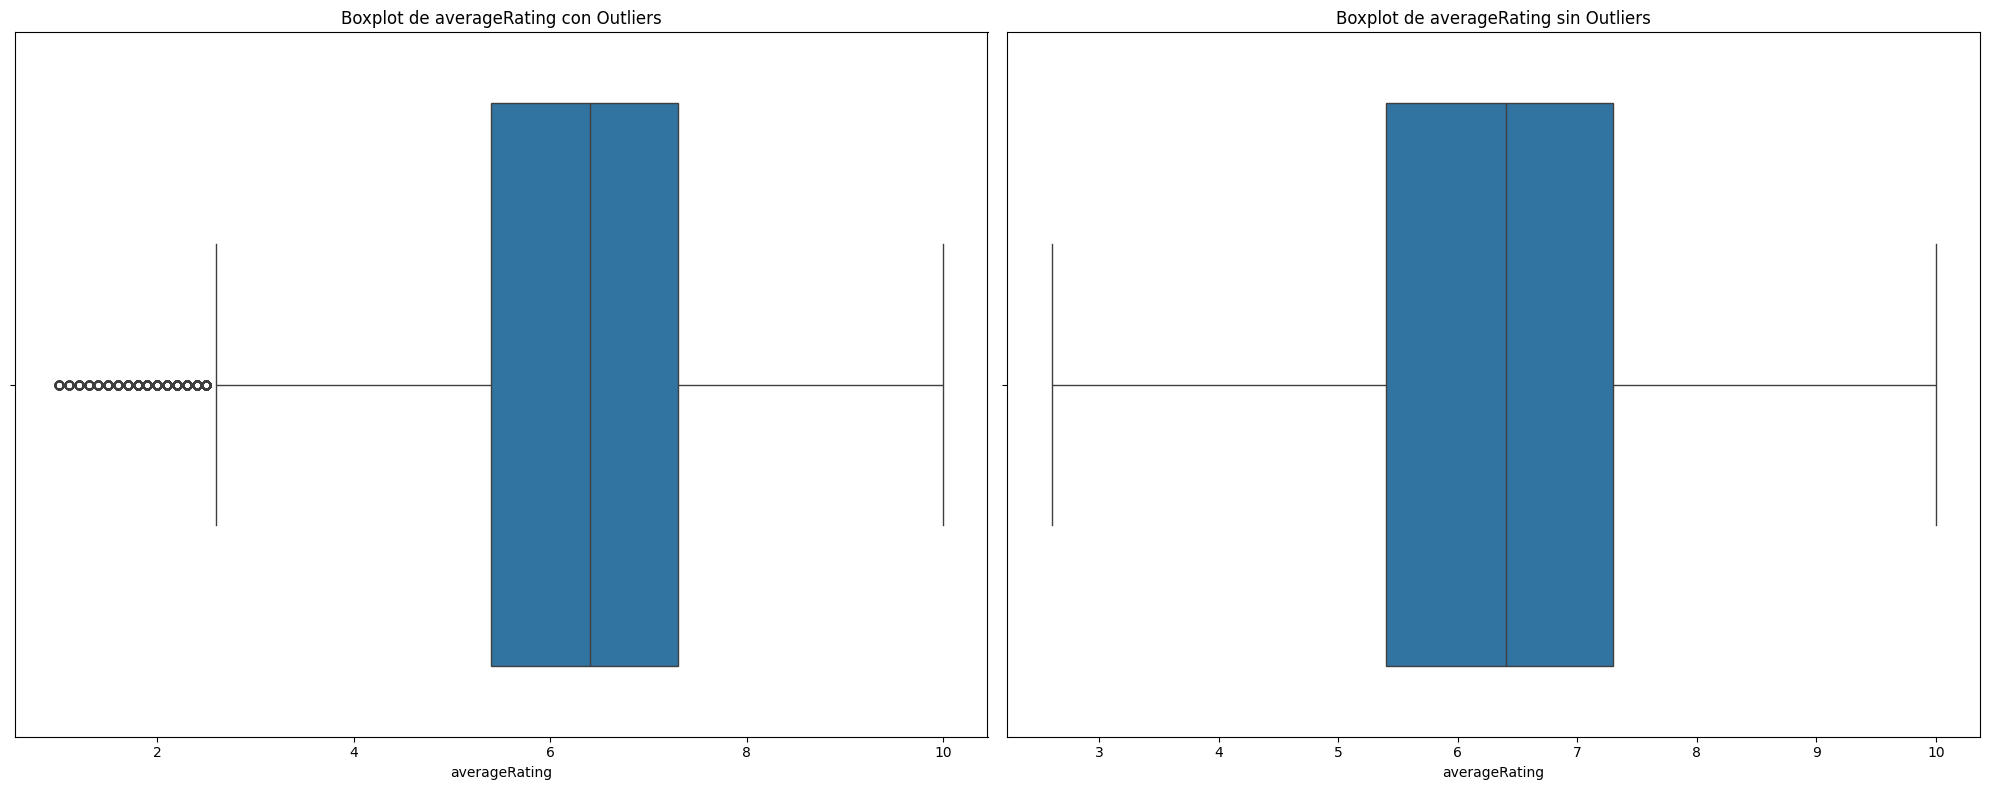

In [ ]:
# Configurar el tamaño de la figura
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Boxplot con outliers
sns.boxplot(x=df_title_ratings['averageRating'], ax=axes[0])
axes[0].set_title('Boxplot de averageRating con Outliers')
axes[0].set_xlabel('averageRating')

# Calcular los límites para los outliers
valorAverageRating = df_title_ratings['averageRating']
Q1 = valorAverageRating.quantile(0.25)
Q3 = valorAverageRating.quantile(0.75)
IIQAR = Q3 - Q1
limite_inferior_valorAverageRating = Q1 - 1.5 * IIQAR
limite_superior_valorAverageRating = Q3 + 1.5 * IIQAR

# Seleccionar los datos sin outliers
seleccionvalorAverageRating = (valorAverageRating >= limite_inferior_valorAverageRating) & (valorAverageRating <= limite_superior_valorAverageRating)
df_sin_outliers = df_title_ratings[seleccionvalorAverageRating]

# Boxplot sin outliers
sns.boxplot(x=df_sin_outliers['averageRating'], ax=axes[1])
axes[1].set_title('Boxplot de averageRating sin Outliers')
axes[1].set_xlabel('averageRating')

# Ajustar diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

Estadísticas de los datos originales:
count   419610.00
mean        81.72
std        157.26
min          1.00
25%         58.00
50%         85.00
75%         98.00
max      59460.00
Name: runtimeMinutes, dtype: Float64

Estadísticas de los datos sin outliers:
count   412326.00
mean        78.25
std         30.81
min          1.00
25%         58.00
50%         84.00
75%         97.00
max        158.00
Name: runtimeMinutes, dtype: Float64


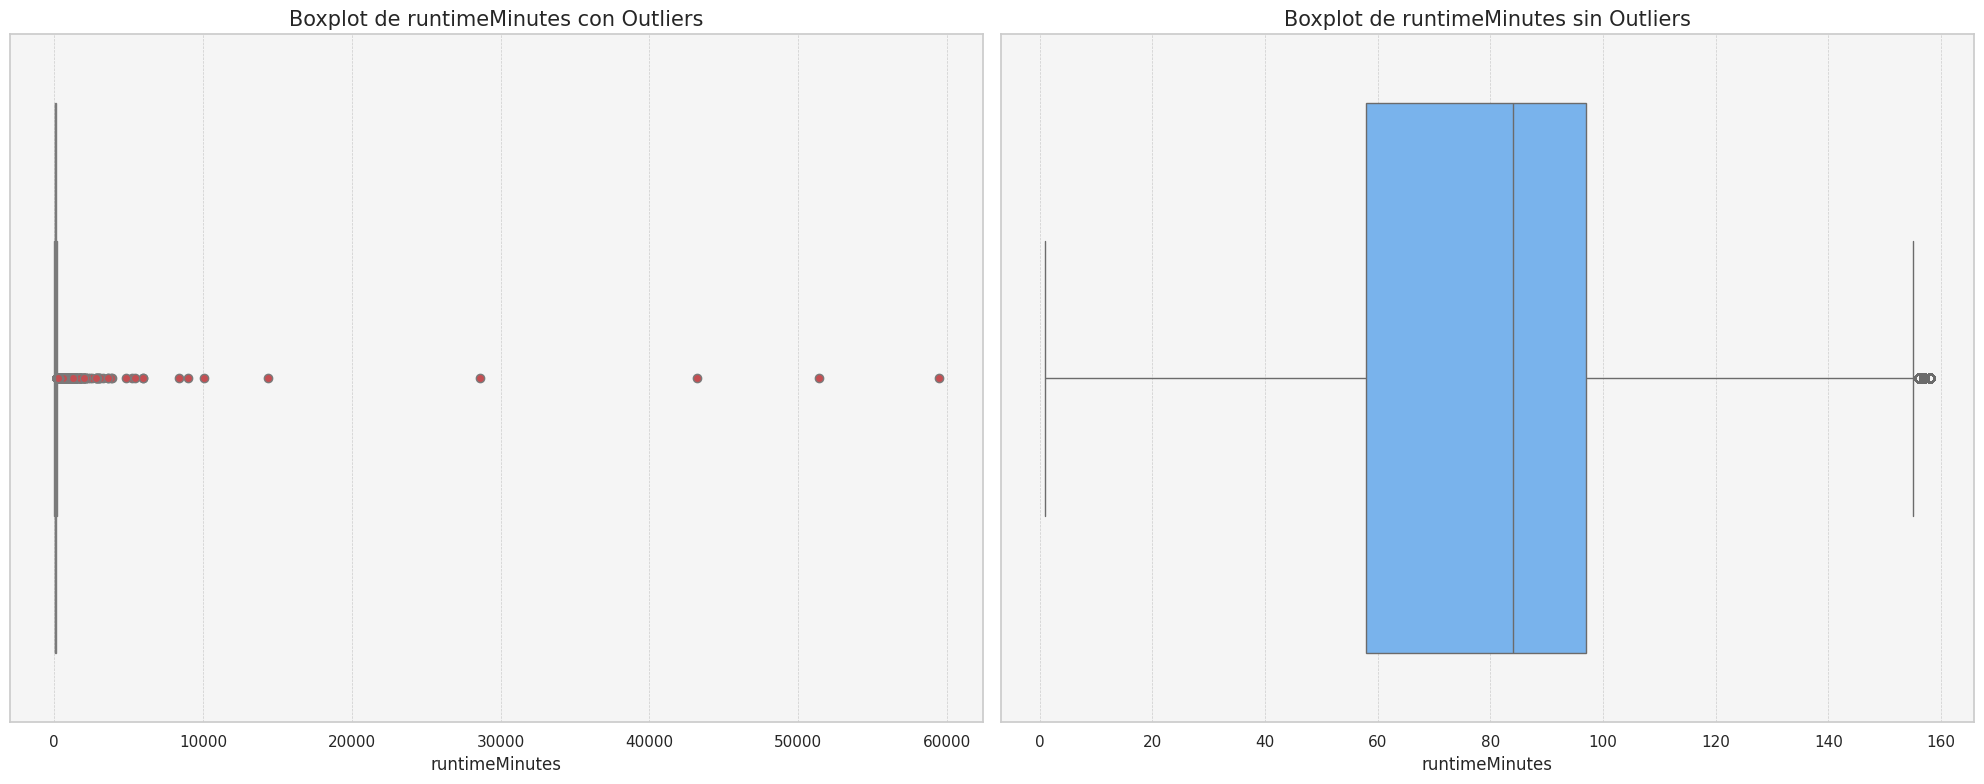

In [ ]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Calcular los límites para los outliers
valorRuntimeMinutes = df_title_basics['runtimeMinutes']
Q1 = valorRuntimeMinutes.quantile(0.25)
Q3 = valorRuntimeMinutes.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Seleccionar los datos sin outliers
seleccion = (valorRuntimeMinutes >= limite_inferior) & (valorRuntimeMinutes <= limite_superior)
df_title_basics_sin_outliers = df_title_basics[seleccion]

# Imprimir estadísticas de los datos originales y filtrados
print("Estadísticas de los datos originales:")
print(df_title_basics['runtimeMinutes'].describe())
print("\nEstadísticas de los datos sin outliers:")
print(df_title_basics_sin_outliers['runtimeMinutes'].describe())

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Fondo mejorado
for ax in axes:
    ax.set_facecolor('#f5f5f5')
    ax.grid(True, linestyle='--', linewidth=0.5)

# Boxplot CON outliers
sns.boxplot(x=df_title_basics['runtimeMinutes'], ax=axes[0], orient='h', color='#ff9999', flierprops=dict(markerfacecolor='r', marker='o'))
axes[0].set_title('Boxplot de runtimeMinutes con Outliers', fontsize=15)
axes[0].set_xlabel('runtimeMinutes', fontsize=12)
axes[0].set_ylabel('')

# Boxplot SIN outliers
sns.boxplot(x=df_title_basics_sin_outliers['runtimeMinutes'], ax=axes[1], orient='h', color='#66b3ff')
axes[1].set_title('Boxplot de runtimeMinutes sin Outliers', fontsize=15)
axes[1].set_xlabel('runtimeMinutes', fontsize=12)
axes[1].set_ylabel('')

# Ajustar diseño
plt.tight_layout()
plt.show()

# Actualizar df_title_basics para que quede con los datos sin outliers
#df_title_basics = df_title_basics_sin_outliers

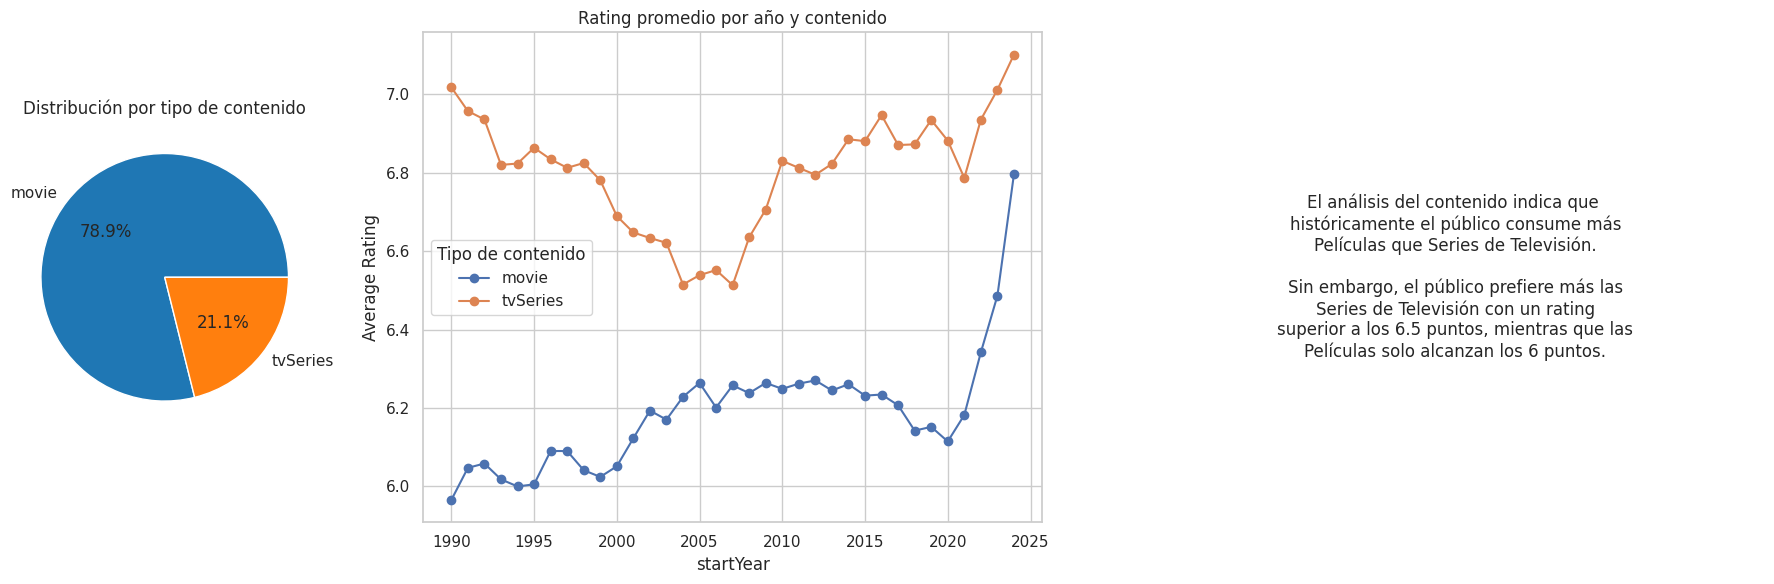

In [ ]:
# Contar el número de películas y series de televisión
content_counts = df_title_basics['titleType'].value_counts()

# Calcular el rating promedio por año y tipo de contenido
df_merged = pd.merge(df_title_basics, df_title_ratings, on='tconst')
df_filtered = df_merged[df_merged['startYear'] >= 1990]
average_ratings = df_filtered.groupby(['startYear', 'titleType'])['averageRating'].mean().unstack()

# Crear la figura y los subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 2, 2]})

# Gráfico de pastel
axes[0].pie(content_counts, labels=content_counts.index, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Distribución por tipo de contenido')

# Gráfico de líneas
average_ratings.plot(ax=axes[1], marker='o')
axes[1].set_title('Rating promedio por año y contenido')
axes[1].set_ylabel('Average Rating')
axes[1].legend(title='Tipo de contenido')

# Añadir anotaciones
annotation_text = ("El análisis del contenido indica que \n"
                   "históricamente el público consume más\n"
                   "Películas que Series de Televisión.\n\n"
                   "Sin embargo, el público prefiere más las\n"
                   "Series de Televisión con un rating\n"
                   "superior a los 6.5 puntos, mientras que las\n"
                   "Películas solo alcanzan los 6 puntos.")
axes[2].text(0.5, 0.5, annotation_text, ha='center', va='center', fontsize=12)
axes[2].axis('off')

# Ajustar los espacios entre los subplots
plt.tight_layout()
plt.show()

In [ ]:
# Calculamos el rating promedio por género
df_title_basics_expanded = df_title_basics.assign(genre=df_title_basics['genres'].str.split(',')).explode('genre')
df_merged = df_title_basics_expanded.merge(df_title_ratings, on='tconst')
df_genre_stats = df_merged.groupby('genre').agg(avg_rating=('averageRating', 'mean'), movie_count=('tconst', 'count')).reset_index()

# Top 10 por promedio rating más alta (descendente)
top_10_genres = df_genre_stats.sort_values(by='avg_rating', ascending=False).head(10)

# Género y calificación promedio
genres = top_10_genres['genre'].to_numpy()
avg_ratings = top_10_genres['avg_rating'].to_numpy()

In [ ]:
print(df_genre_stats)

          genre  avg_rating  movie_count
0        Action        5.86        29264
1         Adult        5.50         3841
2     Adventure        6.20        17031
3     Animation        6.68        11041
4     Biography        7.02         9089
5        Comedy        6.07        71627
6         Crime        6.13        23253
7   Documentary        7.25        50102
8         Drama        6.33       116551
9        Family        6.40        13950
10      Fantasy        6.03         9357
11    Game-Show        6.17         2116
12      History        6.97         8399
13       Horror        4.97        20855
14        Music        6.87         7238
15      Musical        6.28         3227
16      Mystery        5.98        11610
17         News        6.52         1635
18   Reality-TV        6.28         4914
19      Romance        6.18        27173
20       Sci-Fi        5.51         7210
21        Short        7.10          545
22        Sport        6.78         4217
23    Talk-Show 

<ipython-input-15-2bf0258fa89a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='avg_rating', y='genre', data=df_genre_stats, palette='viridis')


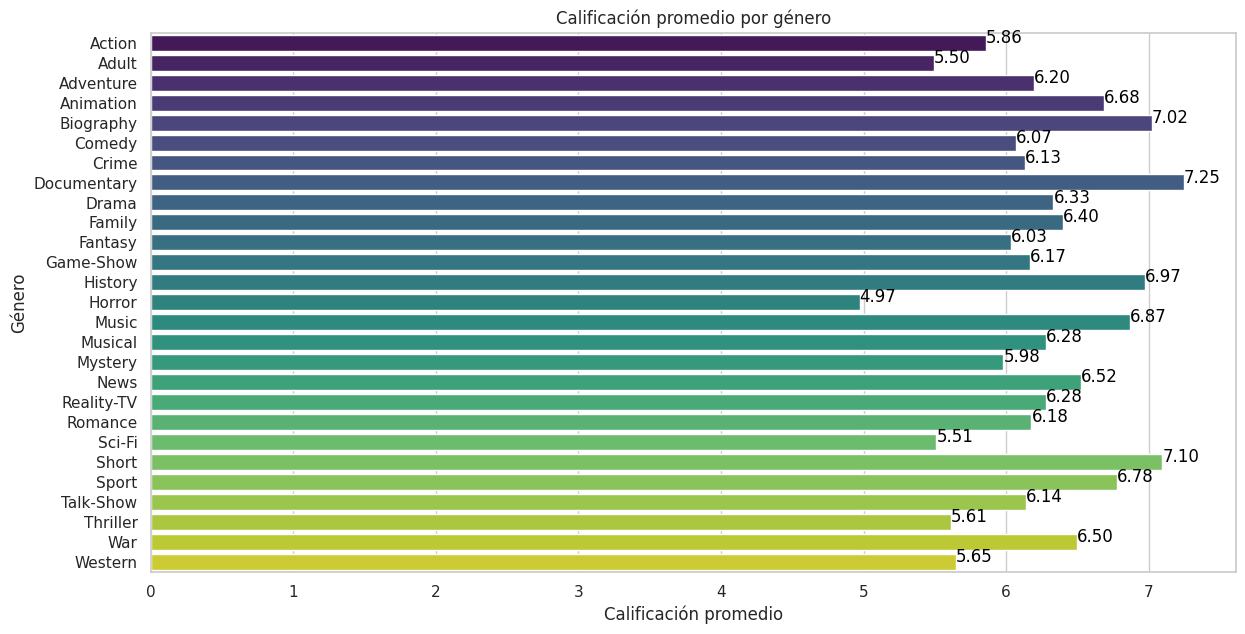

<ipython-input-15-2bf0258fa89a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='movie_count', y='genre', data=df_genre_stats, palette='magma')


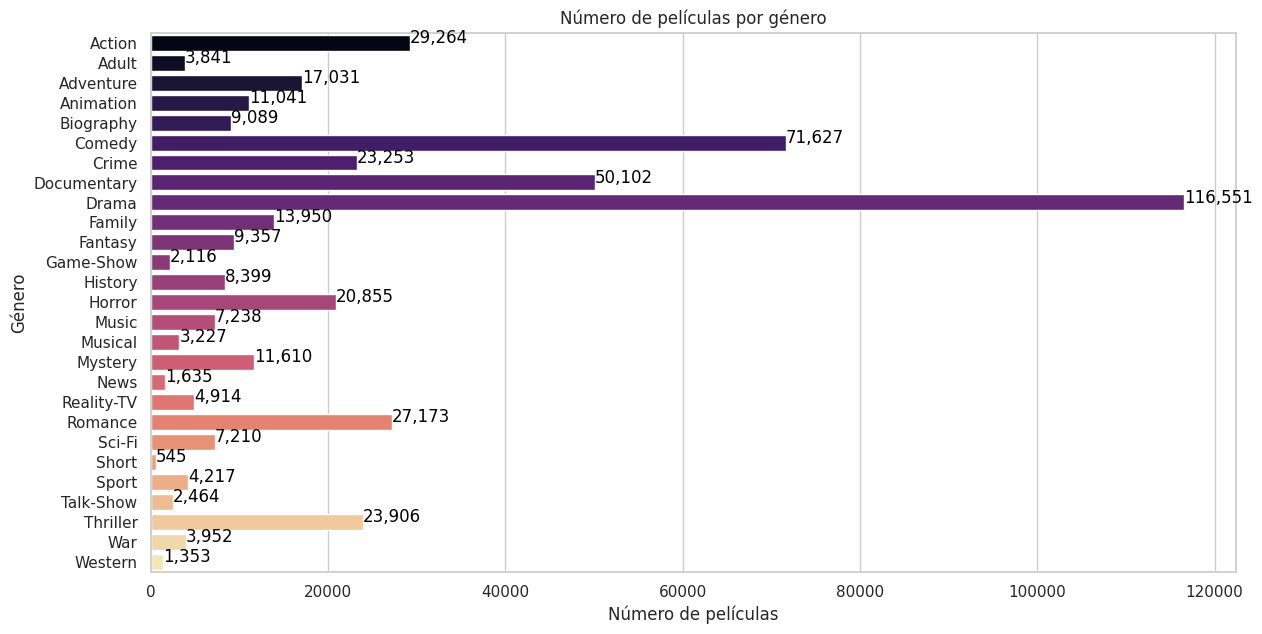

In [ ]:
# Gráfico de barras para las calificaciones promedio por género
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='avg_rating', y='genre', data=df_genre_stats, palette='viridis')
plt.title('Calificación promedio por género')
plt.xlabel('Calificación promedio')
plt.ylabel('Género')

# Añadir anotaciones al gráfico de calificación promedio
for index, value in enumerate(df_genre_stats['avg_rating']):
    barplot.text(value, index, f'{value:.2f}', color='black', ha="left")

plt.show()

# Gráfico de barras para el número de películas por género
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='movie_count', y='genre', data=df_genre_stats, palette='magma')
plt.title('Número de películas por género')
plt.xlabel('Número de películas')
plt.ylabel('Género')

# Añadir anotaciones al gráfico del número de películas
for index, value in enumerate(df_genre_stats['movie_count']):
    barplot.text(value, index, f'{value:,}', color='black', ha="left")

plt.show()

<ipython-input-16-96f510ffe078>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='movie_count', data=df_genre_stats, ax=ax1, order=genre_order, palette='pastel')
<ipython-input-16-96f510ffe078>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Inclinar etiquetas x


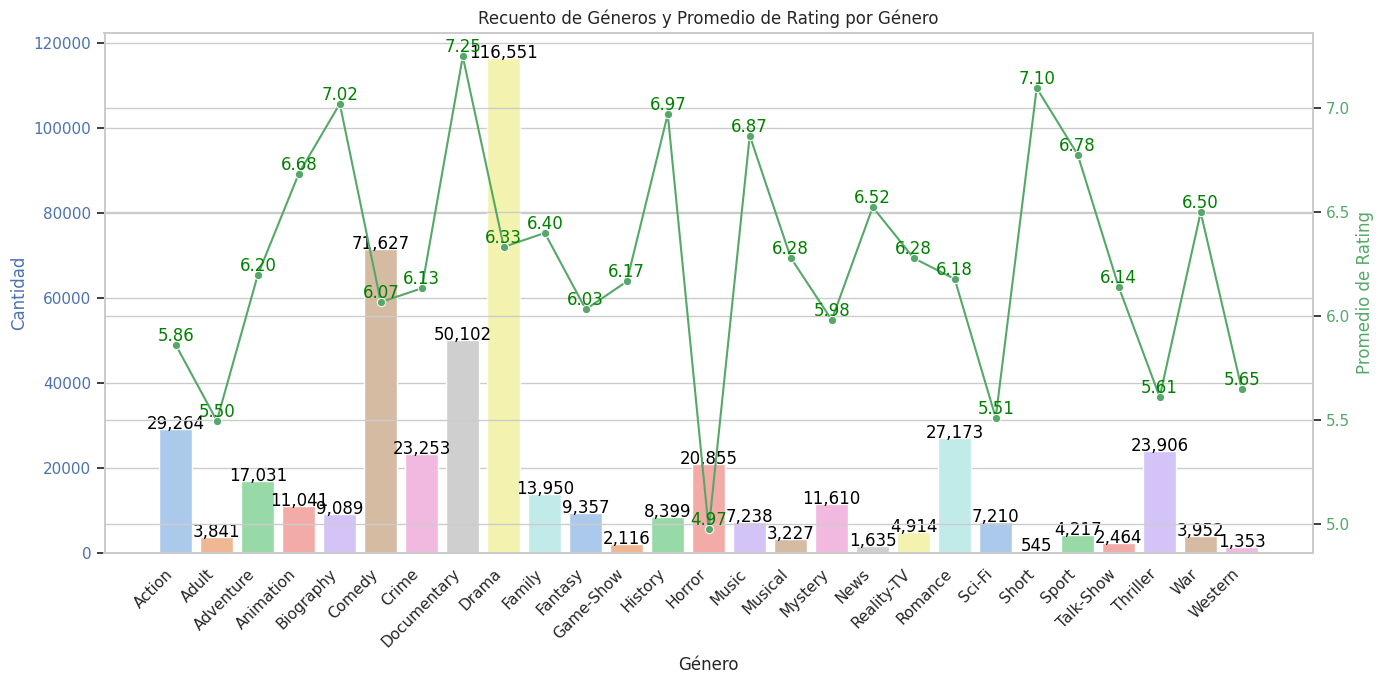

In [ ]:
# Ordenar las categorías por el recuento descendente
df_genres = df_genre_stats.sort_values('movie_count', ascending=False)
genre_order = df_genre_stats['genre']

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de barras (recuento de géneros)
sns.barplot(x='genre', y='movie_count', data=df_genre_stats, ax=ax1, order=genre_order, palette='pastel')
ax1.set_xlabel('Género')
ax1.set_ylabel('Cantidad', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')  # Inclinar etiquetas x

# Añadir anotaciones al gráfico de barras
for index, value in enumerate(df_genre_stats['movie_count']):
    ax1.text(index, value, f'{value:,}', color='black', ha="center")

# Crear un segundo eje y graficar el rating promedio
ax2 = ax1.twinx()
sns.lineplot(data=df_genre_stats, x='genre', y='avg_rating', ax=ax2, color='g', marker='o')
ax2.set_ylabel('Promedio de Rating', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Añadir anotaciones al gráfico de líneas
for index, value in enumerate(df_genre_stats['avg_rating']):
    ax2.text(index, value, f'{value:.2f}', color='green', ha="center", va='bottom')

# Añadir título
plt.title('Recuento de Géneros y Promedio de Rating por Género')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


##**Pregunta 3: ¿Cuáles son los géneros que proporcionan mayor ROI?**




In [ ]:
df_tmdb_expanded = df_tmdb.assign(genre=df_tmdb['genres'].str.split(',').explode('genre').str.strip()).explode('genre')

In [ ]:
# Calcular el ROI promedio por género
df_genre_roi = df_tmdb_expanded.groupby('genre')['roi'].mean().sort_values(ascending=False).head(10)
df_genre_roi

genre
Adventure         1.50
Western           1.49
Fantasy           1.48
Animation         1.45
Action            1.37
War               1.34
Science Fiction   1.32
Family            1.23
Crime             1.16
Thriller          1.05
Name: roi, dtype: float64

<ipython-input-19-87485426a754>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_genre_roi.values, y=df_genre_roi.index, palette='viridis', ax=ax)


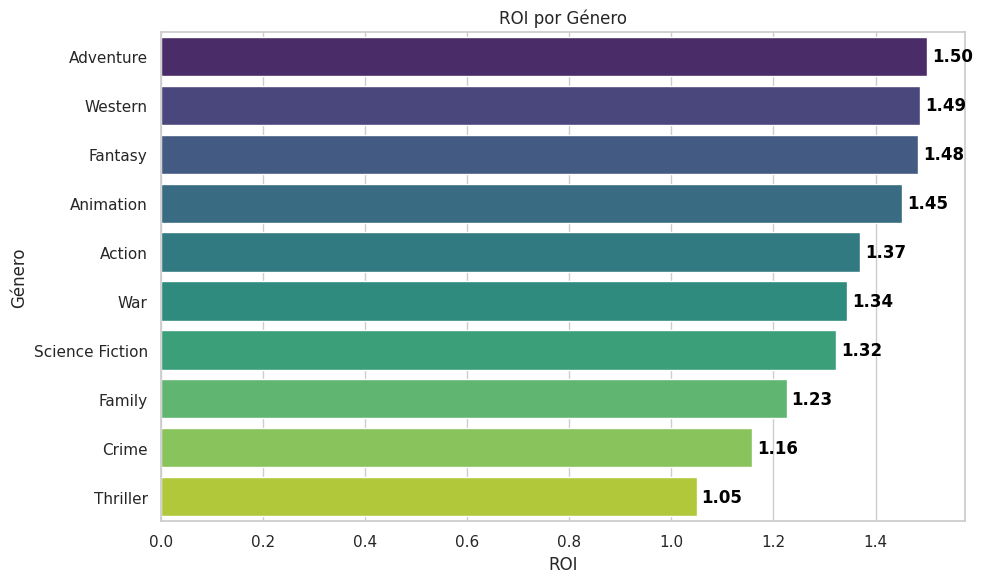

In [ ]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Grafico de barras
sns.barplot(x=df_genre_roi.values, y=df_genre_roi.index, palette='viridis', ax=ax)

# Mostrar valores de ROI en las barras
for i, v in enumerate(df_genre_roi.values):
    ax.text(v + 0.01, i, f'{v:.2f}', va='center', color='black', fontweight='bold')

# Configurar etiquetas y título
ax.set_xlabel('ROI')
ax.set_ylabel('Género')
ax.set_title('ROI por Género')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

def pregunta_4():
    # Definir nuevamente las variables globales (según el entorno y los datos disponibles)
    global df_tmdb, df_title_basics, df_title_ratings, df_plot

    # Preparación de los datos
    # Paso 1: Separar los valores múltiples en producción de países
    df_tmdb_exploded_countries = df_tmdb.assign(production_countries=df_tmdb['production_countries'].str.split(',')).explode('production_countries').copy()
    df_tmdb_exploded_countries['production_countries'] = df_tmdb_exploded_countries['production_countries'].str.strip()

    # Paso 2: Agrupar por país de producción y calcular el ROI promedio y el total de registros
    df_plot = df_tmdb_exploded_countries.groupby('production_countries').agg(avg_roi=('roi', 'mean'), count_movies=('roi', 'size')).reset_index()

    # Renombrar columnas y ordenar por el número de películas (count_movies) de manera descendente
    df_plot.rename(columns={'production_countries': 'country'}, inplace=True)
    df_plot = df_plot.sort_values(by='count_movies', ascending=False)

    # Seleccionar los primeros 10 países con mayor número de películas
    df_top_10 = df_plot.head(10)

    # Asignar posiciones fijas en una cuadrícula para el gráfico de burbujas
    num_countries = len(df_top_10)
    grid_size = int(np.ceil(np.sqrt(num_countries)))
    df_top_10['x'] = np.tile(np.arange(grid_size), grid_size)[:num_countries]
    df_top_10['y'] = np.repeat(np.arange(grid_size), grid_size)[:num_countries]

    # Visualización con Plotly
    fig = px.scatter(df_top_10, x='x', y='y', size='count_movies', color='avg_roi',
                     hover_name='country', text='country',
                     size_max=110, color_continuous_scale='Blues',
                     labels={'avg_roi': 'ROI Promedio', 'count_movies': 'Número de Películas'})

    fig.update_layout(title='ROI Promedio y Número de Películas por País de Producción (Top 10)',
                      xaxis_title='Posición X', yaxis_title='Posición Y',
                      font=dict(family='Arial', size=12, color='black'),
                      plot_bgcolor='white', showlegend=True)

    # Mostrar el gráfico interactivo
    fig.show()

# Ejecutar la función para generar y mostrar el gráfico
pregunta_4()

<ipython-input-20-60e535106686>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['x'] = np.tile(np.arange(grid_size), grid_size)[:num_countries]
<ipython-input-20-60e535106686>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['y'] = np.repeat(np.arange(grid_size), grid_size)[:num_countries]
